In [2]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from network import *

from torch_functions import *

from plot_data import *

seed_everything(42)

In [3]:
d = 1
hidden_dim = 30
hidden_dim_matrix = 30
k = 1

pert = "exponential"

n_train = 30_000
n_stop = 1_000
n_test = 1_000
n_calibration = 1_000
n_anchors = 3

num_epochs_warm_start = 1000
warm_start_epochs_mat = 50
num_epochs_our_loss = 500

n_neighbors = 100

batch_size = 400


class NonLinearFunction1D:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta

    def get(self, x):
        
        # nonlinear_term = np.sin(x/10) + 0.5 * np.tanh((2*x)**2)
        nonlinear_term = np.sin(2 * x)
        return nonlinear_term

f_star = NonLinearFunction1D(d, k)

class RadiusTransformation1D:
    def __init__(self, d, beta=None):
        pass

    def get(self, x):
        return 0.5 + 2.0 * x 
    
    # def get(self, x):
    #     return 1.0
    

radius = RadiusTransformation1D(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=np.eye(k), bias=False, law_x="uniform", scale_noise=0.3)

# x_train, y_train, x_calibration, y_calibration, x_test, y_test = data_generator.generate_train_calibration_test(n_train, n_test, n_calibration)  

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)

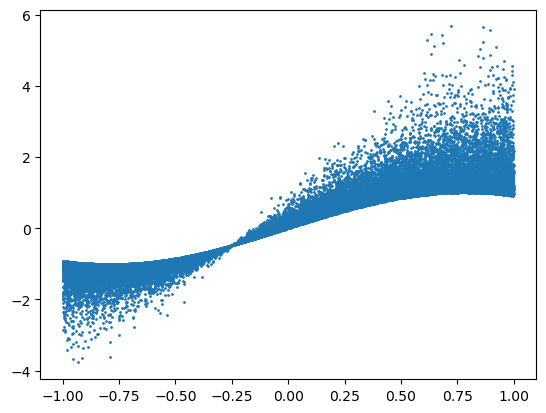

In [4]:
x_samples_plot = np.linspace(-3, 3, 10000)
x_samples = x_samples_plot.reshape(-1, 1)

y_samples = data_generator.generate_y_given_x(x_samples)

# plt.scatter(x_samples_plot, y_samples, label='Train', s=1)  # 's' est pour la taille des points
# plt.close()

plt.scatter(x_train, y_train, label='Train', s=1)  # 's' est pour la taille des points


In [5]:
import json
seed_everything(42)

config_name = "exponential"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)


prop_train = parameters["prop_train"]
prop_calibration = parameters["prop_calibration"]

# Chemin d'entrée et de sortie

d = x_train.shape[1]
k = y_train.shape[1]

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n_calibration = x_calibration.shape[0]
n_stop = x_stop.shape[0]

hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]

num_epochs_warm_start = parameters["num_epochs_warm_start"]
warm_start_epochs_mat = parameters["warm_start_epochs_mat"]
num_epochs_our_loss = parameters["num_epochs_our_loss"]

lr_warm_start = parameters["lr_warm_start"]
lr_model = parameters["lr_model"]
lr_matrix = parameters["lr_matrix"]
lr_q = parameters["lr_q"]

batch_size_warm_start = parameters["batch_size_warm_start"]
batch_size_our_loss = parameters["batch_size_our_loss"]

n_neighbors = parameters["n_neighbors"]
use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"]

num_epochs_rectangles = parameters["num_epochs_rectangles"]
lr_rectangles = parameters["lr_rectangles"]
batch_size_rectangles = parameters["batch_size_rectangles"]

loss_strategy = parameters["loss_strategy"]
use_epsilon = parameters["use_epsilon"]

alpha = parameters["alpha"]
alpha = 0.1
print(alpha)

0.1


In [6]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix)
model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers)
q = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_warm_start, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_warm_start, shuffle=True)
train_losses, stop_losses = model.fit_and_plot(trainloader, stoploader, epochs=num_epochs_warm_start, lr=lr_warm_start, keep_best=keep_best)

warm_start_model = copy.deepcopy(model)



In [7]:
from ellipsoid_predictor import *

model = copy.deepcopy(warm_start_model)
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_our_loss, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_our_loss, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size_our_loss, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size_our_loss, shuffle=True)

ellipsoid_predictor = EllipsoidPredictor(model, matrix_model, q)

ellipsoid_predictor.fit(trainloader, 
                        stoploader, 
                        alpha,
                        num_epochs = num_epochs_our_loss,
                        num_epochs_mat_only = warm_start_epochs_mat,
                        lr_model =lr_model,
                        lr_q = lr_q,
                        lr_matrix_model = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 2,
                        stop_on_best = keep_best,
                        loss_strategy = loss_strategy,
                        use_epsilon = use_epsilon,
                        )

New best stop loss: -0.2149360179901123
Epoch 0: Loss = -0.21448111534118652 - Stop Loss = -0.2149360179901123 - Best Stop Loss = -0.2149360179901123
New best stop loss: -0.22321581840515137
Epoch 1: Loss = -0.27187228202819824 - Stop Loss = -0.22321581840515137 - Best Stop Loss = -0.22321581840515137
New best stop loss: -0.22636300325393677
Epoch 2: Loss = -0.2816457152366638 - Stop Loss = -0.22636300325393677 - Best Stop Loss = -0.22636300325393677
Epoch 3: Loss = -0.23205792903900146 - Stop Loss = -0.219696044921875 - Best Stop Loss = -0.22636300325393677
New best stop loss: -0.23714101314544678
Epoch 4: Loss = -0.23852193355560303 - Stop Loss = -0.23714101314544678 - Best Stop Loss = -0.23714101314544678
Epoch 5: Loss = -0.2688366174697876 - Stop Loss = -0.21266424655914307 - Best Stop Loss = -0.23714101314544678
Epoch 6: Loss = -0.17243313789367676 - Stop Loss = -0.1843101978302002 - Best Stop Loss = -0.23714101314544678
Epoch 7: Loss = -0.27768850326538086 - Stop Loss = -0.225637

In [8]:
ellipsoid_predictor.load_best_model()

In [9]:
from covariances import *
from local_covariances import *

In [10]:
model_final_loss_calibration = ellipsoid_predictor.model.eval(calibrationloader)
warm_start_model_loss_calibration = warm_start_model.eval(calibrationloader)

if model_final_loss_calibration < warm_start_model_loss_calibration:
    covariance_predictor = CovariancePredictor(ellipsoid_predictor.model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)

    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the final model')
else:
    covariance_predictor = CovariancePredictor(warm_start_model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)
    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the warm started model')

keeping the warm started model


In [11]:
from hyper_rectangles import *

hyper_rectangle_predictor = HyperRectanglePredictor(d, k, alpha, hidden_dim = hidden_dim, n_layers = n_hidden_layers)

hyper_rectangle_predictor.fit(x_train, y_train, x_stop, y_stop,
                              num_epochs = num_epochs_rectangles, 
                              lr = lr_rectangles,
                              batch_size = batch_size_rectangles,
                              use_lr_scheduler = use_lr_scheduler,
                              keep_best = keep_best)


In [12]:
covariance_predictor.conformalize(calibrationloader, alpha = alpha)
local_covariance_predictor.conformalize(calibrationloader, alpha = alpha)
ellipsoid_predictor.conformalize(calibrationloader, alpha = alpha)
hyper_rectangle_predictor.conformalize(x_calibration, y_calibration)


99


In [13]:
volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test, y_test)


print(ellipsoid_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(local_covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(coverage_hyper_rectangles)

print("")
print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor))
print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor))
print(local_covariance_predictor.get_averaged_volume(x_test = x_test_tensor))
print(volume_hyper_rectangle)




0.8880000114440918
0.9010000228881836
0.878000020980835
0.8960000276565552

0.696083664894104
1.028458595275879
1.0705268383026123
0.9194831252098083


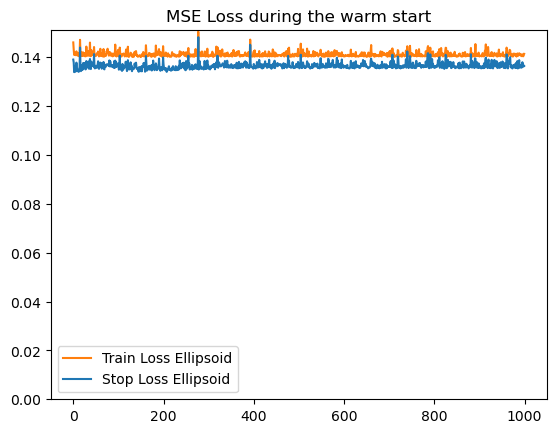

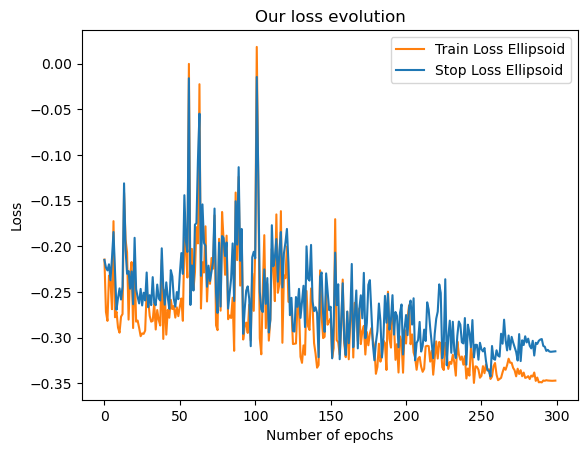

256


In [14]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

# Second plot: Loss evolution
plt.plot(ellipsoid_predictor.tab_train_loss, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(ellipsoid_predictor.tab_stop_loss, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Our loss evolution')
plt.legend()
plt.show()
plt.close()
print(np.argmin(ellipsoid_predictor.tab_stop_loss))


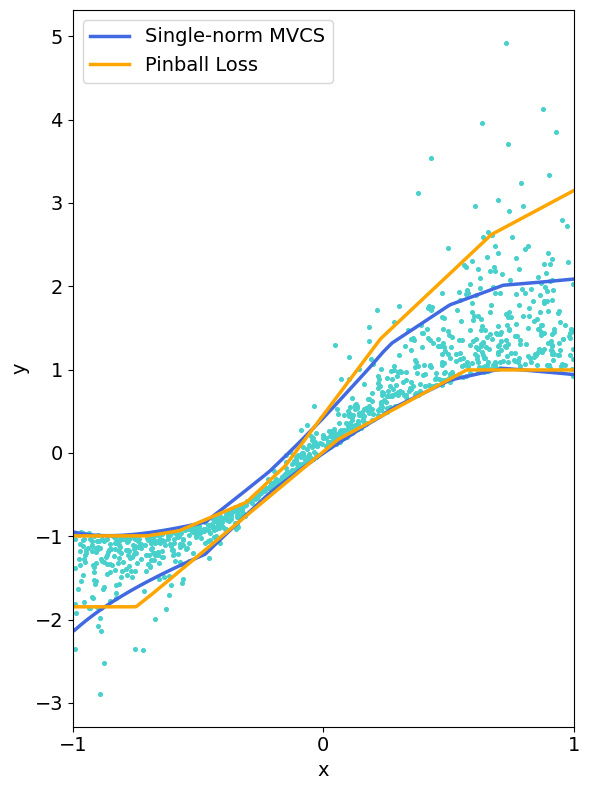

In [15]:
f_x_test = ellipsoid_predictor.model(x_test_tensor)
f_x_test_np = f_x_test.detach().numpy()
Lambdas_test = ellipsoid_predictor.get_Lambdas(x_test_tensor)
sigmas = Lambdas_test.detach().numpy().reshape(-1, 1)
nu_test_np = ellipsoid_predictor.nu_conformal.item()
val = nu_test_np/sigmas



# volume_our = 2*val.mean()
f_x_test_cov = covariance_predictor.model(x_test_tensor)
f_x_test_cov_np = f_x_test_cov.detach().numpy()
Lambdas_test_cov = covariance_predictor.get_Lambdas(x_test_tensor)
sigmas_cov = Lambdas_test_cov.detach().numpy().reshape(-1, 1)
nu_test_cov_np = covariance_predictor.nu_covariance.item()
val_cov = nu_test_cov_np/sigmas_cov
volume_cov = 2*val_cov.mean()

u_pred = hyper_rectangle_predictor.tab_model_alpha_high[0](x_test_tensor).detach().numpy()
d_pred = hyper_rectangle_predictor.tab_model_alpha_low[0](x_test_tensor).detach().numpy()
q_1_alpha = hyper_rectangle_predictor.conformal_value.item()
u_conformal = u_pred + q_1_alpha
d_conformal = d_pred - q_1_alpha

plt.figure(figsize=(6, 8))
plt.scatter(x_test, y_test, label='', s=7, c="mediumturquoise")  # 's' est pour la taille des points
x_test_idx = np.argsort(np.asarray(x_test).flatten())
x_test_reshape = x_test.reshape(-1, 1)
sup = f_x_test_np + val
inf = f_x_test_np - val 
plt.plot(x_test_reshape[x_test_idx], sup[x_test_idx], label='Single-norm MVCS', color='royalblue',linewidth = 2.5)
plt.plot(x_test_reshape[x_test_idx], inf[x_test_idx], color='royalblue',linewidth = 2.5)
sup = f_x_test_cov_np + val_cov
inf = f_x_test_cov_np - val_cov

plt.plot(x_test_reshape[x_test_idx], u_conformal[x_test_idx], label='Pinball Loss', color='orange', linewidth = 2.5)
plt.plot(x_test_reshape[x_test_idx], d_conformal[x_test_idx], color='orange',linewidth = 2.5)
plt.xlabel('x')
plt.ylabel('y')

plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-1, 1)
plt.xticks([-1, 0, 1])
plt.tight_layout()

plt.legend(fontsize = 14)
plt.savefig(f'../figs/5.3.1.1D_coverage{1-alpha}.pdf', dpi = 300)
plt.show()
